<a href="https://colab.research.google.com/github/Willlee0225/nbviewer/blob/master/Stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#coding=utf-8
import pandas as pd
import numpy as np
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector,Input
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from keras.utils import to_categorical
%matplotlib inline

Using TensorFlow backend.


In [0]:
%tensorflow_version 2.x

In [3]:
from google.colab import files
uploaded = files.upload()

Saving data3.csv to data3.csv


In [0]:
import io
df1 = pd.read_csv(io.BytesIO(uploaded['data3.csv']))

In [0]:
def normalize(df):
    norm = df.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))
    return norm

In [0]:
def train_windows(df, ref_day=5, predict_day=1):
    X_train, Y_train = [], []
    for i in range(df.shape[0]-predict_day-ref_day):
        X_train.append(np.array(df.iloc[i:i+ref_day,:-1]))
        Y_train.append(np.array(df.iloc[i+ref_day:i+ref_day+predict_day]["y"]))
    return np.array(X_train), np.array(Y_train)

In [0]:
df1['y'] = df1['DOW'].shift(-1)

In [0]:
df1.iloc[:,[1,2,3,4,5,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29]]=normalize(df1.iloc[:,[1,2,3,4,5,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29]])

In [0]:
df1 = df1.dropna()

In [10]:
df1

,Date,MMM,KO,CVX,CAT,BA,AXP,AAPL,XOM,WMT,WBA,VZ,UNH,TRV,PG,NIKE,MSFT,MRK,JPM,JNJ,INTC,IBM,HD,DIS,MCD,SP,NASDAQ,DOW,BP,y
0,1987/5/20,0.028840,0.012630,0.052596,0.015463,0.018688,0.061161,0.038624,0.029384,0.010524,0.011279,0.007471,0.001533,0.019495,0.023713,0.000171,0.001815,0.002160,0.157860,0.016498,0.004135,0.185534,0.003513,0.028567,0.022746,0.040478,0.024113,0.038398,0.070671,0.039195
1,1987/5/21,0.027702,0.012259,0.052924,0.015772,0.018688,0.065379,0.023103,0.029204,0.012395,0.011279,0.004598,0.001533,0.020714,0.022169,0.000342,0.001933,0.003361,0.165886,0.016613,0.004135,0.186537,0.003634,0.030607,0.023845,0.041939,0.024513,0.039195,0.069336,0.040598
2,1987/5/22,0.028651,0.013930,0.052596,0.016082,0.019803,0.065906,0.012765,0.028483,0.012979,0.011279,0.011494,0.001533,0.020714,0.023492,0.000342,0.001742,0.004801,0.169231,0.016957,0.003609,0.185534,0.003674,0.030862,0.026456,0.043423,0.024281,0.040598,0.070078,0.045003
3,1987/5/26,0.032256,0.016716,0.054568,0.017782,0.020640,0.073815,0.020198,0.030105,0.014032,0.012062,0.017241,0.001594,0.026806,0.027353,0.000342,0.001815,0.004561,0.176589,0.018446,0.004345,0.191953,0.003875,0.035709,0.028655,0.048605,0.025122,0.045003,0.070671,0.044832
4,1987/5/27,0.032635,0.015973,0.054897,0.019020,0.024266,0.072233,0.024033,0.029564,0.014500,0.012376,0.022988,0.001533,0.028024,0.026470,0.000513,0.001815,0.005761,0.170569,0.018217,0.004345,0.192555,0.004517,0.036729,0.028518,0.048321,0.025375,0.044832,0.070449,0.046028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5994,2011/2/25,0.931998,0.719138,0.978015,0.961800,0.649266,0.639277,0.050898,0.887972,0.735267,0.809307,0.457412,0.666112,0.974266,0.832990,0.952716,0.443202,0.277753,0.695197,0.815512,0.286594,0.975802,0.536488,0.972200,0.922157,0.817131,0.523291,0.836302,0.788283,0.844019
5995,2011/2/28,0.956041,0.714502,0.995372,0.971004,0.646354,0.639932,0.054005,0.890164,0.738709,0.836778,0.476839,0.667054,0.980700,0.835955,0.964208,0.443708,0.282132,0.695358,0.841909,0.281346,0.973235,0.542196,0.991809,0.938517,0.822603,0.523548,0.844019,0.793771,0.830473
5996,2011/3/1,0.934548,0.726270,0.986430,0.940622,0.627376,0.633052,0.061157,0.881742,0.740056,0.824346,0.458434,0.665014,0.966858,0.831578,0.949651,0.436624,0.280864,0.677860,0.831057,0.280269,0.960976,0.531804,0.973193,0.928094,0.807028,0.514117,0.830473,0.810753,0.831179
5997,2011/3/2,0.944991,0.720565,0.992426,0.951607,0.621854,0.630922,0.080897,0.884973,0.738559,0.806700,0.464978,0.682438,0.958865,0.826919,0.956547,0.435275,0.282247,0.671599,0.832670,0.281615,0.962195,0.530341,0.980640,0.925455,0.808601,0.516358,0.831179,0.822024,0.846583


In [11]:
from google.colab import files
uploaded = files.upload()

Saving test3.csv to test3.csv


In [0]:
import io
df2 = pd.read_csv(io.BytesIO(uploaded['test3.csv']))

In [0]:
df2['y'] = df2['DOW'].shift(-1)

In [0]:
df2.iloc[:,[1,2,3,4,5,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29]]=normalize(df2.iloc[:,[1,2,3,4,5,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29]])

In [0]:
df2 = df2.dropna()

In [0]:
df1.drop(['Date'], axis=1, inplace=True)

In [0]:
df2.drop(['Date'], axis=1, inplace=True)

In [56]:
df2

,MMM,KO,CVX,CAT,BA,AXP,AAPL,XOM,WMT,WBA,VZ,UNH,TRV,PG,NIKE,MSFT,MRK,JPM,JNJ,INTC,IBM,HD,DIS,MCD,SP,NASDAQ,DOW,BP,y
0,0.114385,0.061712,0.605110,0.391397,0.035150,0.014275,0.342770,0.730426,0.043017,0.189984,0.099827,0.006491,0.112561,0.046627,0.039286,0.012183,0.048530,0.149144,0.028002,0.040990,0.538379,0.038259,0.114318,0.022273,0.092220,0.054776,0.075927,0.929971,0.082508
1,0.121577,0.068871,0.614535,0.409099,0.038178,0.030454,0.212826,0.728781,0.048022,0.197961,0.116062,0.007515,0.113487,0.051581,0.040074,0.013334,0.050940,0.159879,0.031170,0.039367,0.557796,0.039037,0.115786,0.017211,0.097332,0.057468,0.082508,0.878910,0.082440
2,0.118487,0.068531,0.594320,0.393432,0.038308,0.028445,0.279226,0.725764,0.050763,0.201211,0.121934,0.010021,0.116634,0.050852,0.039374,0.013213,0.055922,0.161299,0.028002,0.040787,0.587375,0.041920,0.115134,0.018831,0.096545,0.055590,0.082440,0.879090,0.070348
3,0.101652,0.062905,0.556369,0.358293,0.036220,0.017553,0.316355,0.684629,0.050524,0.191609,0.113299,0.007364,0.108488,0.043421,0.037128,0.010304,0.049655,0.152160,0.019928,0.032468,0.555647,0.039174,0.109834,0.024906,0.085652,0.048813,0.070348,0.870550,0.073512
4,0.110176,0.054722,0.566911,0.372721,0.037134,0.020302,0.291395,0.694776,0.049809,0.191166,0.094300,0.006604,0.111821,0.043421,0.034182,0.011940,0.046923,0.154024,0.020746,0.034091,0.559035,0.039495,0.113584,0.025243,0.089662,0.050764,0.073512,0.856796,0.070801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2218,0.566489,0.837027,0.819546,0.799876,0.711699,0.875859,0.069022,0.527081,0.848189,0.443640,0.981347,0.964549,0.833102,0.984701,0.964885,0.819747,0.991322,0.982699,0.900256,0.829748,0.334628,0.876207,0.951973,0.844897,0.936102,0.891656,0.952045,0.125584,0.942354
2219,0.558871,0.834299,0.813965,0.793149,0.701939,0.866448,0.067549,0.521459,0.845925,0.442015,0.970294,0.956502,0.830232,0.961096,0.955902,0.811443,0.983770,0.978174,0.895657,0.820414,0.314302,0.864034,0.935828,0.836393,0.927912,0.883552,0.942354,0.115876,0.946392
2220,0.562014,0.837027,0.822151,0.794565,0.700269,0.868457,0.037899,0.525572,0.839252,0.442754,0.976857,0.956995,0.834490,0.967361,0.961851,0.812110,0.982484,0.985006,0.901482,0.825081,0.324465,0.868930,0.942841,0.841118,0.932062,0.887109,0.946392,0.123876,0.963875
2221,0.581087,0.824753,0.833561,0.819791,0.719997,0.882838,0.061638,0.540930,0.840443,0.444527,0.964767,0.951378,0.839674,0.945651,0.972234,0.829808,1.000000,1.000000,0.902504,0.845170,0.335867,0.874788,0.971950,0.862581,0.943898,0.903094,0.963875,0.124056,0.951496


In [0]:
def lstm_stock_model(shape):
    model = Sequential()
    model.add(LSTM(256, input_shape=(shape[1], shape[2]), return_sequences=True))
    model.add(LSTM(256, return_sequences=True))
    model.add(TimeDistributed(Dense(1)))
    model.add(Flatten())
    model.add(Dense(5,activation='tanh'))
    model.add(Dense(1,activation='tanh'))
    model.compile(loss="mean_absolute_error", optimizer="adam",metrics=['mean_absolute_error'])
    model.summary()
    return model

In [0]:
X_train, Y_train = train_windows(df1, 5, 1)
X_test, Y_test = train_windows(df2, 5, 1)

In [116]:
model = lstm_stock_model(X_train.shape)
callback = EarlyStopping(monitor="mean_absolute_error", patience=10, verbose=5, mode="auto")

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 5, 256)            291840    
_________________________________________________________________
lstm_6 (LSTM)                (None, 5, 256)            525312    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 5, 1)              257       
_________________________________________________________________
flatten_3 (Flatten)          (None, 5)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 30        
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 6         
Total params: 817,445
Trainable params: 817,445
Non-trainable params: 0
________________________________________________

In [131]:

history = model.fit(X_train, Y_train, epochs=20, batch_size=5, validation_split=0.1, callbacks=[callback],shuffle=True)

Train on 5393 samples, validate on 600 samples
Epoch 1/20
5393/5393 [==============================] - 40s 7ms/step - loss: 0.0099 - mean_absolute_error: 0.0099 - val_loss: 0.0630 - val_mean_absolute_error: 0.0630
Epoch 2/20
5393/5393 [==============================] - 40s 7ms/step - loss: 0.0095 - mean_absolute_error: 0.0095 - val_loss: 0.0626 - val_mean_absolute_error: 0.0626
Epoch 3/20
5393/5393 [==============================] - 40s 7ms/step - loss: 0.0095 - mean_absolute_error: 0.0095 - val_loss: 0.0777 - val_mean_absolute_error: 0.0777
Epoch 4/20
5393/5393 [==============================] - 40s 7ms/step - loss: 0.0091 - mean_absolute_error: 0.0091 - val_loss: 0.0623 - val_mean_absolute_error: 0.0623
Epoch 5/20
5393/5393 [==============================] - 40s 7ms/step - loss: 0.0096 - mean_absolute_error: 0.0096 - val_loss: 0.0584 - val_mean_absolute_error: 0.0584
Epoch 6/20
5393/5393 [==============================] - 40s 7ms/step - loss: 0.0093 - mean_absolute_error: 0.0093 - va

In [132]:
score=model.evaluate(X_test,Y_test,verbose=0)
score

[0.12341432486285644, 0.1234143078327179]

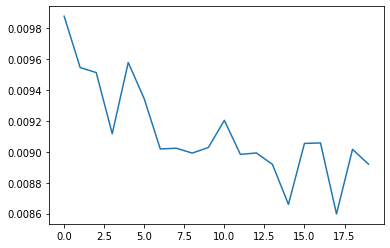

In [133]:
plt.plot(history.history['loss'])

In [0]:
real_stock_price = Y_test

In [135]:
real_stock_price

array([[0.06351146],
       [0.05069824],
       [0.05923385],
       ...,
       [0.94639214],
       [0.96387517],
       [0.95149591]])

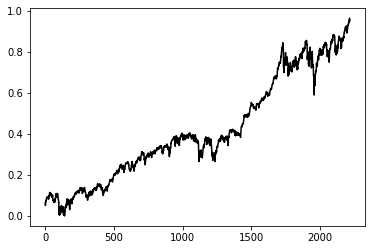

In [136]:
plt.plot(real_stock_price, color = 'black', label = 'DOW Stock Price')

In [0]:
predicted_stock_price = model.predict(X_test)

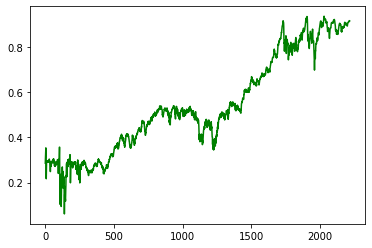

In [138]:
plt.plot(predicted_stock_price, color = 'green', label = 'Predicted DOW Stock Price')

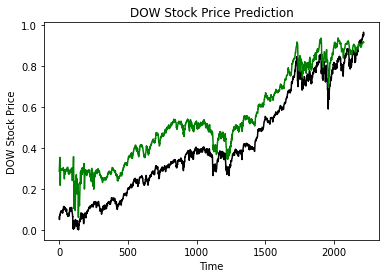

In [139]:
plt.plot(real_stock_price, color = 'black', label = 'DOW Stock Price')
plt.plot(predicted_stock_price, color = 'green', label = 'Predicted DOW Stock Price')
plt.title('DOW Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('DOW Stock Price')
plt.show()

In [0]:
def RNNmodel_predict(n):
    print("實際的道瓊指數是：", real_stock_price[n:n+10])
    print("神經網路RNN的預測是：", predicted_stock_price[n:n+10])
 
    

In [143]:

interact_manual(RNNmodel_predict, n=(0, 2216))

interactive(children=(IntSlider(value=1108, description='n', max=2216), Button(description='Run Interact', sty…

<function __main__.RNNmodel_predict>